Data Loading

In [1]:
import pandas as pd

# Paths to your training data files
amazon_fashion_path = '/Users/allanjensen/Downloads/AMAZON_FASHION.json'
all_beauty_path = '/Users/allanjensen/Downloads/All_Beauty.json'
clothing_shoes_jewelry_path = '/Users/allanjensen/Downloads/Clothing_Shoes_and_Jewelry.json'


# Number of rows to read from each file
n_rows = 300000

# Load a subset of each training dataset
amazon_fashion = pd.read_json(amazon_fashion_path, lines=True, nrows=n_rows)
all_beauty = pd.read_json(all_beauty_path, lines=True, nrows=n_rows)
clothing_shoes_jewelry = pd.read_json(clothing_shoes_jewelry_path, lines=True, nrows=n_rows)

# Concatenate the datasets
training_data = pd.concat([amazon_fashion, all_beauty, clothing_shoes_jewelry])


/var/folders/jw/klwn3fn938q7l19xfc5b_2l40000gn/T/ipykernel_16476/266685231.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


text preprocess 

In [2]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        tokens = word_tokenize(text)
        lemmatized_text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens if word not in stop_words])
        return lemmatized_text
    else:
        return ""

# Apply the preprocessing to your training data
# Ensure that 'training_data' is defined and has a column 'reviewText'
training_data['processed_reviewText'] = training_data['reviewText'].apply(preprocess_text)
training_data = training_data[training_data['processed_reviewText'] != ""]


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/allanjensen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allanjensen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allanjensen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/allanjensen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Sentiment Analysis and Feature Extraction

In [3]:
from nltk import download
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Download the VADER lexicon
download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()
training_data['sentiment_score'] = training_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(training_data['processed_reviewText'])

combined_features = hstack([tfidf_features, training_data['sentiment_score'].values.reshape(-1, 1)])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/allanjensen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Labels and Data Splitting

In [4]:
from sklearn.model_selection import train_test_split

def cat_y(overall_rating):
    if overall_rating in [1, 2]:
        return 'low'
    elif overall_rating == 3:
        return 'neutral'
    elif overall_rating in [4, 5]:
        return 'high'

training_data['category'] = training_data['overall'].apply(cat_y)
X_train, X_val, y_train, y_val = train_test_split(combined_features, training_data['category'], test_size=0.2, random_state=42)


dt train og gridsearch 

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid_decision_tree = {
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_decision_tree, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
decision_tree_model = grid_search.best_estimator_


eval på det 

In [6]:
from sklearn.metrics import classification_report

y_val_pred = decision_tree_model.predict(X_val)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

        high       0.85      0.96      0.90    138990
         low       0.62      0.51      0.56     24887
     neutral       0.42      0.07      0.13     15743

    accuracy                           0.82    179620
   macro avg       0.63      0.52      0.53    179620
weighted avg       0.78      0.82      0.79    179620



overfit?

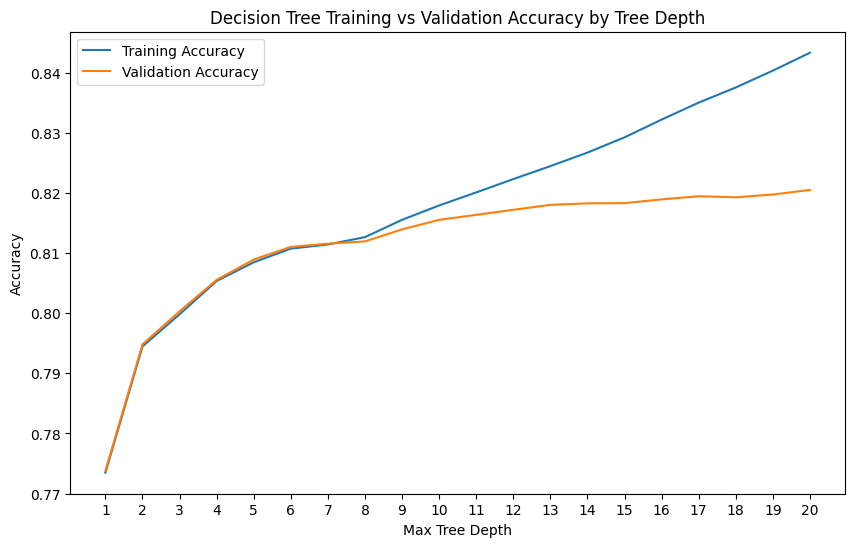

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Range of tree depths to evaluate
max_depths = range(1, 21)  # You can adjust the range as needed

train_accuracies = []
val_accuracies = []

for depth in max_depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Training accuracy
    train_preds = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    train_accuracies.append(train_accuracy)
    
    # Validation accuracy
    val_preds = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)
    val_accuracies.append(val_accuracy)

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy')
plt.plot(max_depths, val_accuracies, label='Validation Accuracy')
plt.title('Decision Tree Training vs Validation Accuracy by Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(max_depths)
plt.show()


chat siger: 
This code chunk will create a plot showing how the accuracy of the Decision Tree model varies with different maximum depths on both the training and validation sets. Typically, if the model overfits, you will see the training accuracy continue to increase with depth, while the validation accuracy may plateau or even decrease, indicating that the model is fitting too closely to the training data and not generalizing well to new data.

final test med lucxury beauty (husk at rette nrows)

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from nltk.sentiment import SentimentIntensityAnalyzer

# Assuming your preprocessing and sentiment analysis functions are already defined
# preprocess_text(text)
# cat_y(rating)


# Load test dataset
test_data = pd.read_json('/Users/allanjensen/Downloads/Luxury_Beauty_5.json', lines=True)

# Preprocess the text data
test_data['processed_reviewText'] = test_data['reviewText'].apply(preprocess_text)

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
test_data['sentiment_score'] = test_data['processed_reviewText'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply the same TF-IDF vectorizer to the test data
# Assuming tfidf_vectorizer is already fitted to the training data
tfidf_features_test = tfidf_vectorizer.transform(test_data['processed_reviewText'])

# Combine TF-IDF features with sentiment scores
combined_features_test = hstack([tfidf_features_test, test_data['sentiment_score'].values.reshape(-1, 1)])

# Categorize the ratings in the test data
test_data['category'] = test_data['overall'].apply(cat_y)

# Predict with the trained Decision Tree model
# Ensure decision_tree_model is your trained Decision Tree model
test_predictions = decision_tree_model.predict(combined_features_test)

# Evaluate the model's performance (optional)
print(classification_report(test_data['category'], test_predictions))


              precision    recall  f1-score   support

        high       0.84      0.97      0.90     27803
         low       0.42      0.30      0.35      2591
     neutral       0.46      0.05      0.09      3884

    accuracy                           0.82     34278
   macro avg       0.57      0.44      0.45     34278
weighted avg       0.77      0.82      0.77     34278

